In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
data = np.load('data_RL/D11980_170.npy')
data.shape

(50, 250, 250)

In [3]:
# 测试
arr = data.flatten()
# 计算均值和标准差（总体统计量）
mean = np.mean(arr)
std = np.std(arr)
print(mean, std)
# 计算各范围的上下限
lower1 = mean - std
upper1 = mean + std
lower2 = mean - 2 * std
upper2 = mean + 2 * std
lower3 = mean - 3 * std
upper3 = mean + 3 * std

# 统计各范围内的元素数量
count1 = np.sum((arr >= lower1) & (arr <= upper1))
count2 = np.sum((arr >= lower2) & (arr <= upper2))
count3 = np.sum((arr >= lower3) & (arr <= upper3))

# 计算占比（保留两位小数）
total = len(arr)
percent1 = (count1 / total) * 100
percent2 = (count2 / total) * 100
percent3 = (count3 / total) * 100

# 输出结果
print(f"数据总数: {total}")
print(f"均值±1σ范围内数据占比: {percent1:.2f}%")
print(f"均值±2σ范围内数据占比: {percent2:.2f}%")
print(f"均值±3σ范围内数据占比: {percent3:.2f}%")

0.8376712 2.3634725
数据总数: 3125000
均值±1σ范围内数据占比: 80.90%
均值±2σ范围内数据占比: 92.83%
均值±3σ范围内数据占比: 97.62%


In [4]:
# 确定基准上下限
lower_bound = lower3
upper_bound = upper3

# 对所有图像进行截断和归一化
norm_imgs = []
for img in data:
    clipped = np.clip(img, lower_bound, upper_bound)
    normalized = ((clipped - lower_bound) / (upper_bound - lower_bound)) * 255
    norm_imgs.append(normalized.astype(np.float32))

imgs = np.array(norm_imgs)
print(imgs.shape)

(50, 250, 250)


In [5]:
from skimage.metrics import structural_similarity

# 计算SSIM
def ssim(image1, image2):
    return structural_similarity(image1, image2, data_range=255.0)

# 测试
temp = []
for i in range(imgs.shape[0]):
    temp.append(ssim(imgs[i], imgs[30]))
np.array(temp).round(3)

array([0.18 , 0.184, 0.186, 0.19 , 0.185, 0.179, 0.177, 0.177, 0.175,
       0.172, 0.169, 0.169, 0.163, 0.151, 0.143, 0.144, 0.15 , 0.166,
       0.168, 0.152, 0.156, 0.193, 0.224, 0.216, 0.251, 0.336, 0.378,
       0.299, 0.394, 0.675, 1.   , 0.676, 0.402, 0.307, 0.39 , 0.353,
       0.268, 0.234, 0.237, 0.21 , 0.175, 0.17 , 0.188, 0.197, 0.19 ,
       0.18 , 0.183, 0.193, 0.209, 0.215])

In [6]:
# 经验回放池
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [7]:
# 环境
class SosEnv:
    def __init__(self, nsos, bestsos):
        self.nsos = nsos
        self.bestsos = bestsos
        self.sos = 0

    def step(self, action):
        # 根据action从action_map中选择声速操作
        action_map = [-1, 1]
        next_sos = self.sos + action_map[action]
        # 如果声速越限则不采取动作
        if next_sos > self.nsos - 1:
            next_sos = self.sos
        if next_sos < 0:
            next_sos = self.sos

        # 每走一步的奖励为 (-1+SSIM)*5
        reward = ((-1 + ssim(imgs[next_sos], imgs[self.bestsos])) * 5).round(2)
        done = False
        # 在最佳声速处奖励为10
        if next_sos == self.bestsos:
            reward = 10
            done = True
        # 在边界处奖励为-10
        if next_sos == self.nsos - 1 or next_sos == 0:
            reward = -10
        # 更新sos
        self.sos = next_sos

        return next_sos, reward, done

    def reset(self, seed=None):
        np.random.seed(seed)
        # 随机选择初始声速位置
        start = np.concatenate([
            np.arange(int(self.nsos * 0.2), int(self.nsos * 0.3)),
            np.arange(int(self.nsos * 0.8), int(self.nsos * 0.9))
        ])
        self.sos = np.random.choice(start)

        return self.sos

# 测试
# env = SosEnv(50, 35)
# sos = env.reset()
# action = 0
# for _ in range(30):
#     next_sos, reward, done = env.step(action)
#     print(next_sos, reward, done)

In [8]:
# CNN卷积神经网络
class ConvQnet(nn.Module):
    def __init__(self, action_dim, in_channels=1):
        super(ConvQnet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8)),

            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )


    def forward(self, x):
        x = x / 255.0
        x = self.features(x)
        return x

class NiNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(NiNBlock, self).__init__()
        self.nin = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
        )

    def forward(self, x):
        return self.nin(x)

class NiN(nn.Module):
    def __init__(self, in_channels=1, action_dim=2):
        super(NiN, self).__init__()
        self.nin = nn.Sequential(
            NiNBlock(in_channels=in_channels, out_channels=64, kernel_size=7, stride=3, padding=0),
            nn.MaxPool2d(2),
            NiNBlock(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(2),
            NiNBlock(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),

            nn.Dropout(0.5),
            NiNBlock(in_channels=256, out_channels=action_dim, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.nin(x)

# 测试
TestNet = ConvQnet(action_dim=2)
state = torch.from_numpy(imgs).unsqueeze(1).float()
state = torch.randn(1, 1, 250, 250)
print(f"State.shape: {state.shape}")
action = TestNet(state)
action.shape

State.shape: torch.Size([1, 1, 250, 250])


torch.Size([1, 2])

In [9]:
class DQN:
    def __init__(self, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        # Q网络
        self.q_net = ConvQnet(action_dim=self.action_dim).to(device)
        # 目标网络
        self.target_q_net = ConvQnet(action_dim=self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.device = device  # 运行设备
        self.count = 0  # 计数器,记录更新次数

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon / ((self.count/50.0) + 1):
            action = np.random.randint(self.action_dim)
        else:
            state = torch.from_numpy(imgs[state]).unsqueeze(0).unsqueeze(0).float().to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):  # 更新QNet和目标QNet
        # (state, action, reward, done, next_state)
        img_idx = transition_dict['states']
        states = torch.from_numpy(imgs[img_idx]).unsqueeze(1).float().to(self.device)
        img_idx = transition_dict['next_states']
        next_states = torch.from_numpy(imgs[img_idx]).unsqueeze(1).float().to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # Q值
        q_values = self.q_net(states).gather(1, actions)
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        # TD误差目标
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        # 均方误差损失函数
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        # 训练
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        # 更新目标网络
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.count += 1

    def copy_net(self, net):
        net.load_state_dict(self.target_q_net.state_dict())
        return net

In [10]:
lr = 1e-2
gamma = 0.98
epsilon = 0.8
action_dim = 2
target_update = 10
buffer_size = 2048
minimal_size = 256
batch_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

env = SosEnv(nsos=50, bestsos=30)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(action_dim, lr, gamma, epsilon, target_update, device)

return_list = []

num_episodes = 30
for i_episode in range(int(num_episodes)):
    episode_return = 0
    state = env.reset()
    start = state
    # print(state)
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        print(state, action, reward, next_state, done)
        state = next_state
        episode_return += reward
        # 当buffer数据的数量超过一定值后,才进行Q网络训练
        if replay_buffer.size() > minimal_size:
            b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
            transition_dict = {
                'states': b_s,
                'actions': b_a,
                'next_states': b_ns,
                'rewards': b_r,
                'dones': b_d
            }
            agent.update(transition_dict)
    return_list.append(episode_return)
    print(f"episode:{i_episode}  start:{start}  return:{episode_return}")
    print("=" * 80)

44 0 -4.01 43 False
43 0 -4.06 42 False
42 0 -4.15 41 False
41 1 -4.06 42 False
42 0 -4.15 41 False
41 1 -4.06 42 False
42 1 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 1 -4.05 44 False
44 1 -4.1 45 False
45 0 -4.05 44 False
44 0 -4.01 43 False
43 0 -4.06 42 False
42 1 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 0 -4.06 42 False
42 0 -4.15 41 False
41 0 -4.12 40 False
40 0 -3.95 39 False
39 1 -4.12 40 False
40 1 -4.15 41 False
41 1 -4.06 42 False
42 1 -4.01 43 False
43 0 -4.06 42 False
42 1 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 1 -4.05 44 False
44 0 -4.01 43 False
43 1 -4.05 44 False
44 1 -4.1 45 False
45 0 -4.05 44 False
44 1 -4.1 45 False
45 1 -4.09 46 False
46 1 -4.03 47 False
47 1 -3.95 48 False
48 1 -10 49 False
49 1 -10 49 False
49 1 -1

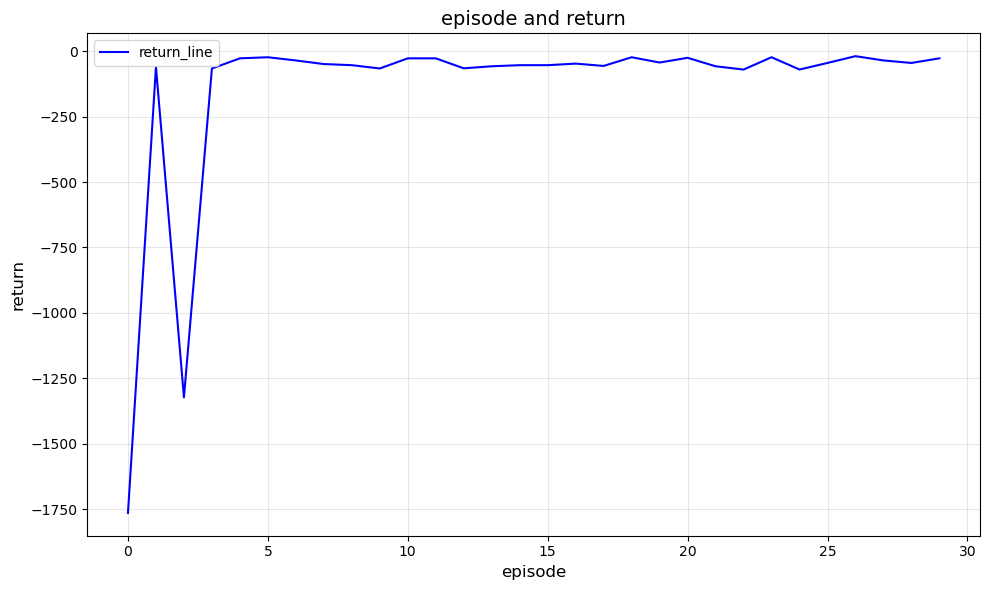

In [11]:
# 创建折线图
plt.figure(figsize=(10, 6))  # 设置图像大小
plt.plot(range(num_episodes), return_list, label='return_line', color='blue', linewidth=1.5)

# 添加标题和标签
plt.title('episode and return', fontsize=14)
plt.xlabel('episode', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.grid(alpha=0.3)  # 添加网格线
plt.legend()  # 显示图例

# 显示图像
plt.tight_layout()  # 调整布局
plt.show()

In [12]:
net = ConvQnet(action_dim=2)
agent.copy_net(net)

states_test = torch.from_numpy(imgs).unsqueeze(1).float()
Q_test = net(states_test)
output = torch.argmax(Q_test, dim=1)
mapping = torch.tensor([-1, 1])
mapping[output.reshape(-1, 10)]

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])